In [1]:
import pandas as pd
import os
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chisquare, chi2_contingency
from scipy.special import expit

In [14]:
csvDir_young='/data/backed_up/shared/dev_1_f/group_fooof/all_sub_results_RestingState_psdWelch512_fmax40_max4peaks_alpha8to12.csv'
csvDir_old='/data/backed_up/shared/CMI_data/MIPDB/preproc_rerun_fooofs/all_sub_results_psdWelch512_fmax40_adjustedPeaks_max4peaks_alpha8to12_05_01_2020.csv'

dat_young=pd.read_csv(csvDir_young)
dat_old=pd.read_csv(csvDir_old)


# have to rename the columns for the young dataset because they only have 'eyes open' and no "eyes closed"

rename_dict={a:(a[:3]+'EO_'+a[3:]) for a in dat_young.columns if a not in ['sub','age'] }
dat_young=dat_young.rename(columns=rename_dict)

#create grouping variable
dat_young['data_group'] = 1
dat_old['data_group'] = 0

# and then combine the datasets
both_sets=pd.concat([dat_young,dat_old])

In [4]:
both_sets.columns

Index(['UnnEO_amed: 0', 'sub', 'age', 'PO_EO_slope', 'PO_EO_yint',
       'MF_EO_slope', 'MF_EO_yint', 'PO_EO_alphaPeak', 'PO_EO_alphaBW',
       'PO_EO_alphaAMP', 'PO_EO_betaPeak', 'PO_EO_betaBW', 'PO_EO_betaAMP',
       'PO_EO_thetaPeak', 'PO_EO_thetaBW', 'PO_EO_thetaAMP', 'MF_EO_alphaPeak',
       'MF_EO_alphaBW', 'MF_EO_alphaAMP', 'MF_EO_betaPeak', 'MF_EO_betaBW',
       'MF_EO_betaAMP', 'MF_EO_thetaPeak', 'MF_EO_thetaBW', 'MF_EO_thetaAMP',
       'MF_EO_Peak_1', 'MF_EO_AMP_1', 'MF_EO_BW_1', 'PO_EO_Peak_1',
       'PO_EO_AMP_1', 'PO_EO_BW_1', 'PO_EO_Peak_2', 'PO_EO_AMP_2',
       'PO_EO_BW_2', 'MF_EO_Peak_2', 'MF_EO_AMP_2', 'MF_EO_BW_2',
       'PO_EO_Peak_3', 'PO_EO_AMP_3', 'PO_EO_BW_3', 'datEO_a_group', 'sex',
       'PO_EC_slope', 'PO_EC_yint', 'MF_EC_slope', 'MF_EC_yint',
       'PO_EC_alphaPeak', 'PO_EC_alphaBW', 'PO_EC_alphaAMP', 'PO_EC_betaPeak',
       'PO_EC_betaBW', 'PO_EC_betaAMP', 'PO_EC_thetaPeak', 'PO_EC_thetaBW',
       'PO_EC_thetaAMP', 'MF_EC_alphaPeak', 'MF_EC_alp

## Identifying max peaks per subject

In [23]:
#extracting highest power peaks within each frequency band, and running a regression of power/frequency by age

MF_EC_BandPeaksDf=pd.DataFrame()
MF_EO_BandPeaksDf=pd.DataFrame()
PO_EC_BandPeaksDf=pd.DataFrame()
PO_EO_BandPeaksDf=pd.DataFrame()

# loop thru row for each subject
for row in range(len(both_sets)):
    thisRow=both_sets.iloc[row]
    thisSub=thisRow['sub']
    thisAge=thisRow['age']
    thisSex=thisRow['sex']
    thisGroup=thisRow['data_group']
    
    # set up temporary dictionaries to keep track of high peak power for this sub
    dict_keys=['maxAlpha_power','maxAlpha_freq','maxTheta_power', 'maxTheta_freq',
           'maxDelta_power', 'maxDelta_freq','maxBeta_power', 'maxBeta_freq',
              'maxthetaTOalpha_power','maxthetaTOalpha_freq']
    elec_clusters={'MF_EC':{},'MF_EO':{},'PO_EC':{},'PO_EO':{}}
    
    for key in elec_clusters.keys():
        for maxs in dict_keys:
            elec_clusters[key][maxs]=np.nan
    
    # loop thru columns to find appropriate peaks
    for col in both_sets.columns:
        for elec_cluster in elec_clusters.keys():
            if (elec_cluster in col) and ("_Peak_" in col):
                # we have to loop thru the types of peaks, and find the ones that 
                # fall within each delta, theta, alpha, beta range
                # Once found, we want to extract the ones w highest power and store them

                thisPeak=thisRow[col]
                thisPeakNum=col[-1] #get the peak number so we can find the corresponding AMP
                thisAMP=thisRow[elec_cluster+'_AMP_'+thisPeakNum] # get the amplitude of this peak
                
                if 4 <= thisPeak <=12: # if this peak is within the theta-alpha range
                    if np.isnan(elec_clusters[elec_cluster]['maxthetaTOalpha_power']) or (thisAMP > elec_clusters[elec_cluster]['maxAlpha_power']): # and this alpha peak is the highest we've found,
                        elec_clusters[elec_cluster]['maxthetaTOalpha_power']=thisAMP # replace our known 'max' with this one
                        elec_clusters[elec_cluster]['maxthetaTOalpha_freq']=thisPeak

                if 8 <= thisPeak <=12: # if this peak is within the alpha range
                    if np.isnan(elec_clusters[elec_cluster]['maxAlpha_power']) or (thisAMP > elec_clusters[elec_cluster]['maxAlpha_power']): # and this alpha peak is the highest we've found,
                        elec_clusters[elec_cluster]['maxAlpha_power']=thisAMP # replace our known 'max' with this one
                        elec_clusters[elec_cluster]['maxAlpha_freq']=thisPeak
                        
                if thisPeak <4:
                    if np.isnan(elec_clusters[elec_cluster]['maxDelta_power']) or (thisAMP > elec_clusters[elec_cluster]['maxDelta_power']):
                        elec_clusters[elec_cluster]['maxDelta_power']=thisAMP
                        elec_clusters[elec_cluster]['maxDelta_freq']=thisPeak
                
                if 4<= thisPeak < 8:
                    if np.isnan(elec_clusters[elec_cluster]['maxTheta_power']) or (thisAMP > elec_clusters[elec_cluster]['maxTheta_power']):
                        elec_clusters[elec_cluster]['maxTheta_power']=thisAMP
                        elec_clusters[elec_cluster]['maxTheta_freq']=thisPeak
                
                if thisPeak >12:
                    if np.isnan(elec_clusters[elec_cluster]['maxBeta_power']) or (thisAMP> elec_clusters[elec_cluster]['maxBeta_power']):
                        elec_clusters[elec_cluster]['maxBeta_power']=thisAMP
                        elec_clusters[elec_cluster]['maxBeta_freq']=thisPeak
                        
    # once we've found all of the peaks, we want to save this out into our seperate df's for this sub
    for key in elec_clusters.keys():
        elec_clusters[key]['sub']=thisSub
        elec_clusters[key]['age']=thisAge
        elec_clusters[key]['sex']=thisSex
        elec_clusters[key]['data_group']=thisGroup
        
    MF_EC_BandPeaksDf=MF_EC_BandPeaksDf.append(elec_clusters['MF_EC'],ignore_index=True)
    MF_EO_BandPeaksDf=MF_EO_BandPeaksDf.append(elec_clusters['MF_EO'],ignore_index=True)
    PO_EC_BandPeaksDf=PO_EC_BandPeaksDf.append(elec_clusters['PO_EC'],ignore_index=True)
    PO_EO_BandPeaksDf=PO_EO_BandPeaksDf.append(elec_clusters['PO_EO'],ignore_index=True) 

In [24]:
PO_EO_BandPeaksDf.columns

Index(['age', 'data_group', 'maxAlpha_freq', 'maxAlpha_power', 'maxBeta_freq',
       'maxBeta_power', 'maxDelta_freq', 'maxDelta_power', 'maxTheta_freq',
       'maxTheta_power', 'maxthetaTOalpha_freq', 'maxthetaTOalpha_power',
       'sex', 'sub'],
      dtype='object')

In [17]:

both_sets['data_group'].values


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

## Logistic regression

In [28]:
x_alpha=list(PO_EO_BandPeaksDf[np.isfinite(PO_EO_BandPeaksDf['maxAlpha_freq'])].age)
print(x_alpha)
x_alpha.sort()
print(x_alpha)
print(len(x_alpha))

[4.638356164, 4.484931507, 2.997260274, 6.071038251, 13.0, 10.0, 8.0, 13.0, 10.0, 9.0, 14.0, 8.0, 9.0, 19.0, 24.0, 13.0, 24.0, 22.0, 23.0, 12.0, 14.0, 13.0, 17.0, 8.0, 15.0, 12.0, 9.0, 12.0, 9.0, 9.0, 24.0, 17.0, 14.0, 12.0, 13.0, 13.0, 11.0, 16.0, 13.0, 10.0, 18.0, 10.0, 14.0, 15.0, 22.0, 11.0, 10.0, 14.0, 23.0, 10.0, 14.0, 11.0, 15.0, 8.0]
[2.997260274, 4.484931507, 4.638356164, 6.071038251, 8.0, 8.0, 8.0, 8.0, 9.0, 9.0, 9.0, 9.0, 9.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 11.0, 11.0, 11.0, 12.0, 12.0, 12.0, 12.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 15.0, 15.0, 15.0, 16.0, 17.0, 17.0, 18.0, 19.0, 22.0, 22.0, 23.0, 23.0, 24.0, 24.0, 24.0]
54


In [72]:
x_alpha=list(PO_EO_BandPeaksDf[np.isfinite(PO_EO_BandPeaksDf['maxAlpha_freq'])].age)
x_alpha_group=list(PO_EO_BandPeaksDf[np.isfinite(PO_EO_BandPeaksDf['maxAlpha_freq'])].data_group)
#x_alpha.sort()
alpha_labels=['alpha']*len(x_alpha)
y_alpha=[1]*len(x_alpha)

x_theta=list(PO_EO_BandPeaksDf[np.isfinite(PO_EO_BandPeaksDf['maxTheta_freq'])].age)
x_theta_group=list(PO_EO_BandPeaksDf[np.isfinite(PO_EO_BandPeaksDf['maxTheta_freq'])].data_group)

#x_theta.sort()
theta_labels=['theta']*len(x_theta)
y_theta=[0]*len(x_theta)

ys=np.asarray(y_theta+y_alpha) # concatenate the arrays
xs=np.asarray(x_theta+x_alpha).reshape(-1,1)

xs=sm.add_constant(xs)
xs = np.column_stack((xs,np.array(x_theta_group+x_alpha_group)))


In [73]:

xs

array([[ 1.        ,  3.00547945,  1.        ],
       [ 1.        ,  5.29041096,  1.        ],
       [ 1.        ,  5.27671233,  1.        ],
       [ 1.        ,  4.49041096,  1.        ],
       [ 1.        ,  3.86027397,  1.        ],
       [ 1.        ,  2.95068493,  1.        ],
       [ 1.        ,  3.71780822,  1.        ],
       [ 1.        ,  4.49589041,  1.        ],
       [ 1.        ,  3.79726027,  1.        ],
       [ 1.        ,  3.76438356,  1.        ],
       [ 1.        ,  2.97808219,  1.        ],
       [ 1.        ,  3.82191781,  1.        ],
       [ 1.        ,  3.77260274,  1.        ],
       [ 1.        ,  5.26027397,  1.        ],
       [ 1.        ,  3.75616438,  1.        ],
       [ 1.        ,  4.51780822,  1.        ],
       [ 1.        ,  3.03561644,  1.        ],
       [ 1.        ,  5.28767123,  1.        ],
       [ 1.        ,  3.04657534,  1.        ],
       [ 1.        ,  5.25956284,  1.        ],
       [ 1.        ,  5.94246575,  1.   

In [9]:
ys

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [74]:
mod=sm.Logit(ys,xs)
result=mod.fit(method='newton')

Optimization terminated successfully.
         Current function value: 0.327550
         Iterations 8


In [75]:
print(len(x_theta))
print(len(x_alpha))
print(len(xs))

28
54
82


In [9]:
res_pred=result.predict(xs)

In [76]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   82
Model:                          Logit   Df Residuals:                       79
Method:                           MLE   Df Model:                            2
Date:                Fri, 10 Jul 2020   Pseudo R-squ.:                  0.4898
Time:                        13:43:54   Log-Likelihood:                -26.859
converged:                       True   LL-Null:                       -52.644
Covariance Type:            nonrobust   LLR p-value:                 6.335e-12
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3120      1.879     -0.166      0.868      -3.995       3.371
x1             0.2162      0.164      1.318      0.187      -0.105       0.538
x2            -2.3810      1.308     -1.820      0.069      -4.945       0.183
==============================================================================
"""

In [11]:
pred_input=np.linspace(3,np.max(xs[:,1])+20,20008)
pred_input=sm.add_constant(pred_input)
predictions=result.predict(pred_input)

In [13]:
print(predictions[2045:2055])
print(pred_input[2045:2055])

[0.49996735 0.50022836 0.50048937 0.50075039 0.5010114  0.50127241
 0.50153342 0.50179443 0.50205544 0.50231645]
[[1.         7.19078323]
 [1.         7.19283251]
 [1.         7.19488179]
 [1.         7.19693107]
 [1.         7.19898036]
 [1.         7.20102964]
 [1.         7.20307892]
 [1.         7.20512821]
 [1.         7.20717749]
 [1.         7.20922677]]


## Plot results

In [77]:
jitter_y=([y+np.random.uniform(-0.045,0.045) for y in ys])
len(jitter_y)==len(y_theta+y_alpha)
scatPlotDf=pd.DataFrame()
scatPlotDf['freqLabel']=theta_labels+alpha_labels
scatPlotDf['y']=jitter_y
scatPlotDf['age']=x_theta+x_alpha

NameError: name 'pred_input' is not defined

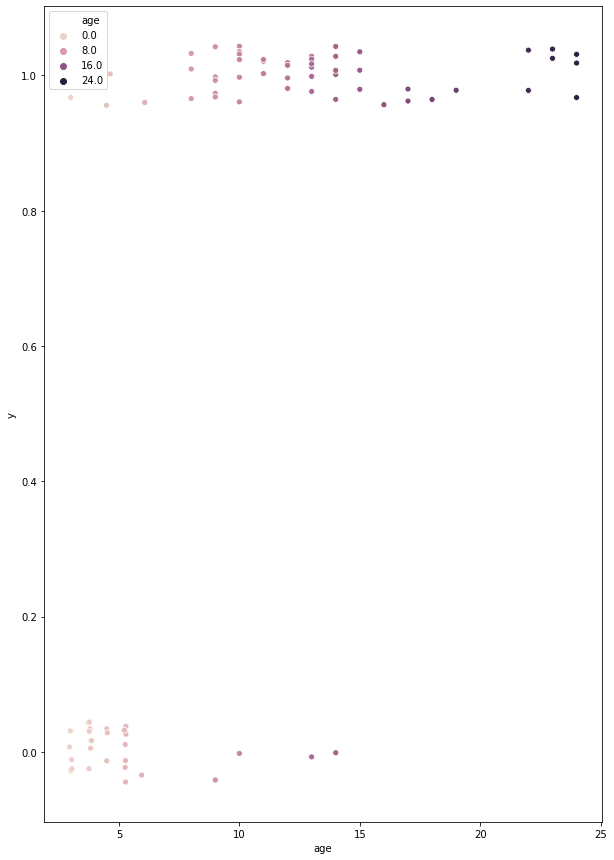

In [78]:
fig,ax=plt.subplots(figsize=(10,15))
#plt.scatter(xs[:,1],jitter_y)
sns.scatterplot(x='age',y='y',data=scatPlotDf,y_jitter=0.04,ax=ax,hue='age')
plt.plot(pred_input[:,1],predictions)
plt.xlim(0,25)
plt.axhline(.5)